# Annealing Unfolder

Based on the SVD example taken from [ROOT's TSVDUnfoldExample](https://root.cern/doc/master/TSVDUnfoldExample_8C.html).

In [10]:
# numpy imports and settings
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=500)
# ROOT imports
import ROOT
import root_numpy
# plotting imports
import pylab as plt
%matplotlib inline

In [11]:
# Set up logger to print in the notebook
import sys, logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.basicConfig(
    stream=sys.stdout,
    format="[%(name)s] %(levelname)s: %(message)s",
    level=logging.DEBUG,
)

Create functions to simulate detector

In [12]:
def reconstruct(xt, R):
    cutdummy = -99999.0
    xeff = 0.3 + (1.0 - 0.3) / 20.0 * (xt + 10.0)
    x = R.Rndm()
    if x > xeff:
        return cutdummy
    return xt + R.Gaus(-2.5, 0.2)

# random utils
R = ROOT.TRandom3()
cutdummy = -99999.0

## Initialization
Generate data

In [58]:
# toy generation
nbins = 40
xini = ROOT.TH1D("xini", "MC truth", nbins, -10, 10)
bini = ROOT.TH1D("bini", "MC reco", nbins, -10, 10)
Adet = ROOT.TH2D("Adet", "detector response", nbins, -10.0, 10.0, nbins, -10.0, 10.0)

# Data
data = ROOT.TH1D("data", "data", nbins, -10.0, 10.0)
# Data "truth" distribution to test the unfolding
datatrue = ROOT.TH1D("datatrue", "data truth", nbins, -10.0, 10.0)
# Statistical covariance matrix
statcov = ROOT.TH2D(
    "statcov", "covariance matrix", nbins, -10.0, 10.0, nbins, -10.0, 10.0
)

Warning in <TROOT::Append>: Replacing existing TH1: xini (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bini (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Adet (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: datatrue (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: statcov (Potential memory leak).


Create the real signal `bini` as a BreitWigner

In [59]:
# Fill the MC using a Breit-Wigner, mean 0.3 and width 2.5.
amount = 100000
#amount = 50
for i in range(amount):
    xt = R.BreitWigner(0.3, 2.5)
    xini.Fill(xt)
    x = reconstruct(xt, R)
    if x != cutdummy:
        Adet.Fill(x, xt)
        bini.Fill(x)

Create the signal `data` with a Gaussian (this is what is measured in the experiment)

In [60]:
# Fill the "data" with a Gaussian, mean 0 and width 2.
amount = 10000
#amount = 30
for i in range(amount):
    xt = R.Gaus(0.0, 2.0)
    datatrue.Fill(xt)
    x = reconstruct(xt, R)
    if x != cutdummy:
        data.Fill(x)

In [61]:
# Fill the data covariance matrix
for i in range(1, data.GetNbinsX()):
    statcov.SetBinContent(i, i, data.GetBinError(i) * data.GetBinError(i))

Turn into python variables and translate Adetpy from a matrix of events (as used in SVD) to a matrix of probabilities (as required by quantum annealing)

In [62]:
# map to numpy arrays
xinipy, xinipy_edges = root_numpy.hist2array(xini, return_edges=True)
binipy, binipy_edges = root_numpy.hist2array(bini, return_edges=True)
Adetpy_events, Adetpy_edges = root_numpy.hist2array(Adet, return_edges=True)

# Data
datapy, datapy_edges = root_numpy.hist2array(data, return_edges=True)
# Data "truth" distribution to test the unfolding
datatruepy, datatruepy_edges = root_numpy.hist2array(datatrue, return_edges=True)
# Statistical covariance matrix
statcovpy, statcovpy_edges = root_numpy.hist2array(statcov, return_edges=True)
# Turn Adetpy from number of events to probabilities (to use it with quantum annealing)
Adetpy = np.true_divide(Adetpy_events, xinipy, where=xinipy!=0)

Plot response matrix and histograms

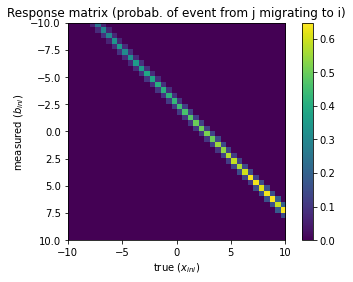

In [63]:
# Show response matrix
left_edge  = xinipy_edges[0][0]
right_edge = xinipy_edges[0][-1]
bottom_edge  = binipy_edges[0][-1]
top_edge = binipy_edges[0][0]
plt.imshow(Adetpy, extent=[left_edge, right_edge, bottom_edge, top_edge])
plt.xlabel("true ($x_{ini}$)")
plt.ylabel("measured ($b_{ini}$)")
plt.title("Response matrix (probab. of event from j migrating to i)")
plt.colorbar()

In [64]:
# Sanity check
bini_candidate = np.dot(Adetpy, xinipy)
print(bini_candidate)
print("Must be equal to")
print(binipy)

[ 126.  170.  196.  249.  317.  375.  447.  596.  738. 1016. 1407. 2112. 3124. 4666. 6743. 8205. 7607. 5651. 4021. 2746. 2005. 1450. 1223.  918.  780.  642.  551.  473.  423.  366.  330.  288.  273.  238.  181.   31.    0.    0.    0.    0.]
Must be equal to
[ 126.  170.  196.  249.  317.  375.  447.  596.  738. 1016. 1407. 2112. 3124. 4666. 6743. 8205. 7607. 5651. 4021. 2746. 2005. 1450. 1223.  918.  780.  642.  551.  473.  423.  366.  330.  288.  273.  238.  209.  178.  191.  150.  133.  142.]


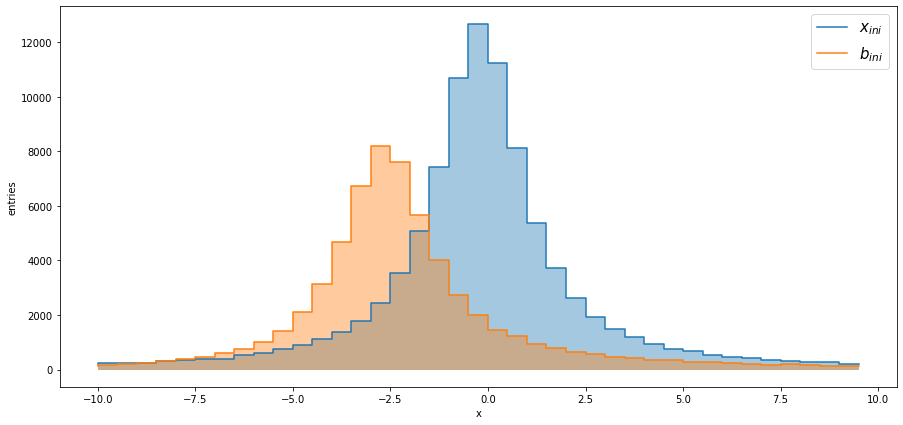

In [65]:
axis = xinipy_edges[0][:-1]
plt.figure(figsize=(15, 7))

# plot x_ini
plt.step(axis, xinipy, fillstyle="bottom", label="$x_{ini}$")
plt.fill_between(axis, xinipy, step="pre", alpha=0.4)
# plot b_ini
plt.step(axis, binipy, fillstyle="bottom", label="$b_{ini}$")
plt.fill_between(axis, binipy, step="pre", alpha=0.4)

plt.xlabel("x")
plt.ylabel("entries")
plt.legend(prop={'size': 15})

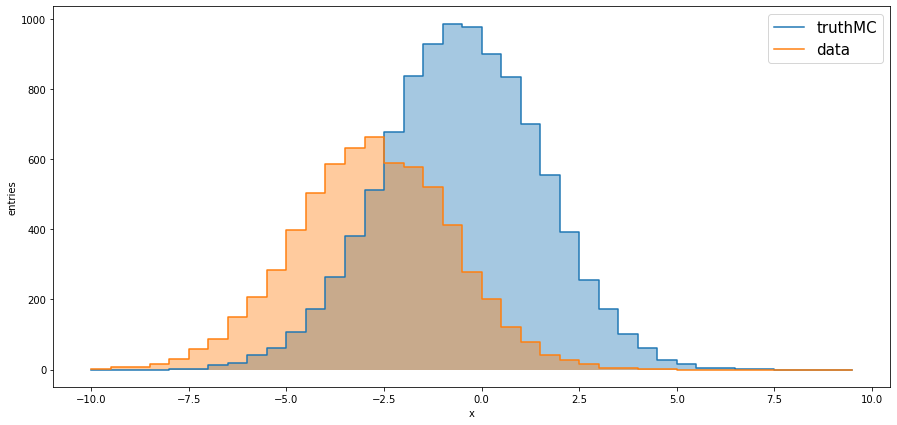

In [66]:
axis = xinipy_edges[0][:-1]
plt.figure(figsize=(15, 7))

# plot truth distribution
plt.step(axis, datatruepy, fillstyle="bottom", label="truthMC")
plt.fill_between(axis, datatruepy, step="pre", alpha=0.4)
# plot what the detector sees
plt.step(axis, datapy, fillstyle="bottom", label="data")
plt.fill_between(axis, datapy, step="pre", alpha=0.4)

plt.xlabel("x")
plt.ylabel("entries")
plt.legend(prop={'size': 15})

## Unfold

In [76]:
# annealing unfolder
from unfolders.annealing import QUBOUnfolder, backends

# unfold with simulated annealing
# adding +1 to avoid division over zero
unfolder_annealing = QUBOUnfolder(
    datatruepy+1, Adetpy, datapy, n_bits=4, weight_regularization=0.5
)
annealer = backends.SimulatedAnnealingBackend(50)
x_unfolded = unfolder_annealing.solve(annealer)

[unfolders.annealing.decimal2binary] DEBUG: Encoding: [  1.   1.   1.   1.   1.   2.   2.  15.  20.  43.  62. 107. 173. 266. 383. 512. 678. 838. 929. 988. 978. 900. 835. 701. 555. 393. 255. 174. 101.  61.  29.  16.   6.   5.   2.   2.   1.   1.   1.   1.]
[unfolders.annealing.decimal2binary] DEBUG: - Encoding x[39]=1.0:
[unfolders.annealing.decimal2binary] DEBUG:   - x_d = x[39] - alpha[39] = 1.0 - 0.5 = 0.5
[unfolders.annealing.decimal2binary] DEBUG:   - Beta = [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    

# Plotting results

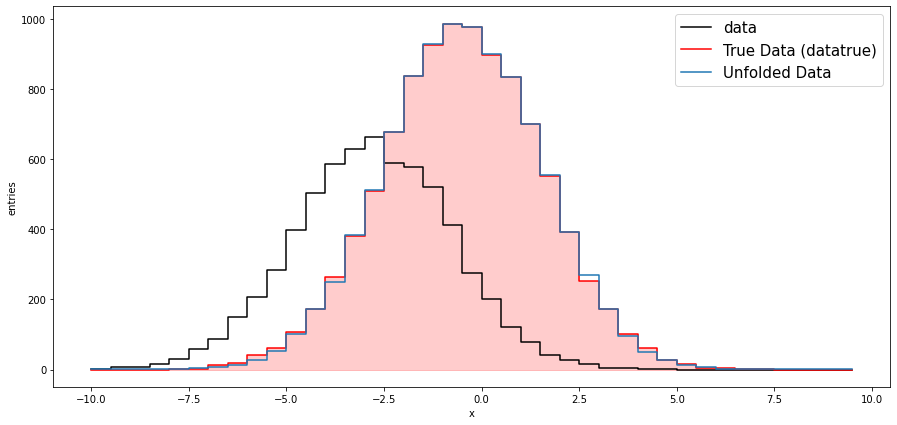

In [77]:
# re-scale xini
# xini.Scale(0.7 * datatrue.Integral() / xini.Integral())
# xinipy, xinipy_edges = root_numpy.hist2array(xini, return_edges=True)

axis = xinipy_edges[0][:-1]
plt.figure(figsize=(15, 7))

# plot the distribution from which the Response matrix is taken
# plt.step(axis, xinipy, fillstyle="bottom", label="True MC ($x_{ini}$)")
# plt.fill_between(axis, xinipy, step="pre", alpha=0.4)
# plot what was measured
plt.step(axis, datapy, fillstyle="bottom", label="data", color="black")
# plot the true data that generated the measurement
plt.step(axis, datatruepy, fillstyle="bottom", label="True Data (datatrue)", color="red")
plt.fill_between(axis, datatruepy, color="red", step="pre", alpha=0.2)
# plot unfolded
plt.step(axis, x_unfolded, fillstyle="bottom", label="Unfolded Data")

plt.xlabel("x")
plt.ylabel("entries")
plt.legend(prop={'size': 15})